# LSTM/QK-VQE
Overview
- calss molecule_data: prepare molecule dataset and pre-processing
- class VQE: build VQE
- calss VQEOptimizer: VQE optimization
- class LSTM: build model
- calss ModelTrain: train and evaluate model

Need to Debug
1. optuna might run for 2-3 hr
2. early convergence in training: dataset size, torch.optim.lr_scheduler.ReduceLROnPlateau
3. FIM approximate
4. val set
5. Gauss. encoding

In [1]:
## basis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
## random
import random
import math
from typing import List, Callable, Tuple
## ML
import torch 
import torch.nn as nn
import torch.optim as optim 
from scipy.optimize import minimize
## QML
import h5py
import pennylane as qml
from pennylane import qchem
## access file 
import os 

In [2]:
torch.manual_seed(42)
np.random.seed(42)
qml.math.random.seed(42)

## Model

In [14]:
class molecule_data:
  """
  Download molecule data from pennylane and data processing
  """
  def __init__(self, molecule_list, ):
    self.molecule_list = molecule_list

  @staticmethod
  def load_data(molecule, basis = "STO-3G", folder_path = "./datasets/"):
    """
    Download data from pennylane

    Args:
     molecule (str, [float]): str for molecule name, [float] for bondlength
     basis (str): default: STO-3G, other: CC-PVDZ and 6-31G
     folder_path (str): path to the directory used for saving datasets. Defaults to './datasets'

    Return:
        DataFrame[:class:`~pennylane.data.Dataset`]

    """
    data_list = []

    print("\n--- Starting Load Data ---")
    for mol_name, bondlengths in molecule:
      if bondlengths is None:
        data = qml.data.load("qchem", molname = mol_name, basis = basis, folder_path = folder_path)
      else:
        data = qml.data.load("qchem", molname = mol_name, basis = basis,folder_path = folder_path, bondlength = bondlengths)

      for entry in data:
        data_list.append(entry)

      df = pd.DataFrame(data_list)

    print("\n--- Complete Load Data ---")
    print(df.head())
    return df

  @staticmethod
  def data_params(df, train_split_index):
    """
    Calculate the basis params like the max qubits we need for this experiment
    Args:
     df [DataFrame]: the molecule dataset for train and test
     train_split_indes [int]: to split the dataset into train set and test set
     
    Return:
     max_qubits [int]: the max qubits we need for this experiment
     max_s_params [int]: the max single params we need for this experiment
     max_d_params [int]: the max double params we need for this experiment
     max_total_params [int]: max_s_params + max_d_params
     train_set [list]
     test_set [list]

    """
    # define max qubits

    max_qubits = 0

    for i in range(len(df[0])):
      if len(df[0][i].hf_state) > max_qubits:
        max_qubits = len(df[0][i].hf_state)

    # find the max params need for single and double
    max_s_params = 0
    max_d_params = 0

    for data in df[0]:
      electrons = sum(data.hf_state)
      orbitals = len(data.hf_state)

      single, double = qchem.excitations(electrons, orbitals)
      s_w, d_w = qml.qchem.excitations_to_wires(single, double)
      num_single = len(s_w)
      num_double = len(d_w)
      max_s_params = max(max_s_params, num_single)
      max_d_params = max(max_d_params, num_double)
    max_total_params = max_s_params + max_d_params

    # split the dataset into train set and test set
    df_list = list(df[0])
    train_set = df_list[:train_split_index]
    test_set = df_list[train_split_index:]

    return max_qubits, max_s_params, max_d_params, max_total_params, train_set, test_set



In [4]:
class VQE:
    """
    Variantional quantum eigensolver algorithm
    """
    def __init__(self, data_entry, max_qubits, max_total_params, with_LSTM = True):# if use single and double linear model, add max_s_params
        """
        Args:
         data_entry (list): molecule data
         max_qubits [int]: the max qubits we need in this experiment
         (max_total_params [int]: the max params from linear output in this experiment
         with_LSTM [bool]: if params come from LSTM-FC: True, otherwise: False
        """
        self.data = data_entry
        self.max_qubits = max_qubits
        self.max_total_params = max_total_params
        self.with_LSTM = with_LSTM
        #self.max_s_params = max_s_params
        """
        To calculate the number of single and double excitation params.need for this molecule, need
         the number of orbitals, electrons to get total_vqe_params, and use this to get the params
         we need from params to obtain uccsd_params for UCCSD ansatz
        """
        self.wires = range(self.max_qubits)
        self.orbitals = len(self.data.hf_state)
        self.electrons = sum(self.data.hf_state)
        self.singles, self.doubles = qchem.excitations(self.electrons, self.orbitals)
        self.s_wires, self.d_wires = qml.qchem.excitations_to_wires(self.singles, self.doubles)
        self.num_single = len(self.s_wires)
        self.num_double = len(self.d_wires)
        self.total_vqe_params = self.num_single + self.num_double

        self.device = qml.device("lightning.qubit", wires = self.wires)
        self.qnode = qml.QNode(self.ansatz, self.device, interface = "torch", diff_method = "adjoint") # change to adjoint if don't use metric

    def ansatz(self, params):

        if self.with_LSTM:
           # if use single linear model
           uccsd_params = params.squeeze(0)[:self.total_vqe_params]
           # if use single and double linear model
           #params = params.squeeze()
           #single_params = params[:self.num_single]
           #double_params = params[self.max_s_params: self.max_s_params + self.num_double]
           #uccsd_params = torch.cat([single_params, double_params], dim = 0)
        else:
            uccsd_params = params
        # UCCSD ansatz
        qml.UCCSD(uccsd_params, wires = range(self.orbitals), s_wires = self.s_wires, d_wires = self.d_wires, init_state = self.data.hf_state)

        return qml.expval(self.data.hamiltonian)
    """
    if need metric, and this takes a long time
    def get_metric_fn(self):
        def metric_fn(p):
            p = torch.tensor(p, requires_grad=True, dtype=torch.float32)
            p = p[:self.total_vqe_params]
            metric = qml.metric_tensor(self.qnode, approx="diag")(p)
            metric_diag = torch.diag(metric)[:self.total_vqe_params]
            metric_diag = metric_diag / (torch.max(torch.abs(metric_diag)) + 1e-8)
            if self.total_vqe_params < self.max_total_params:
              metric_diag = torch.nn.functional.pad(metric_diag, (0, self.max_total_params - self.total_vqe_params), value=1.0)
            return metric_diag
        return metric_fn
    """
    def get_loss_function(self):
        #def loss_fn(theta):
        #  theta = theta.to(self.device, dtype=torch.float32)
        #  theta.requires_grad_(True)
        #  energy = self.qnode(theta)
        #  grad = torch.autograd.grad(energy, theta, create_graph=True)[0]
        #  grad_norm = torch.norm(grad, p=2)
        #  return energy, grad_norm

        return  lambda theta: self.qnode(theta) #loss_fn 

class VQEOptimizer:
    """
    VQE optimization by ADAM or SGD
    """
    def __init__(self, vqe_problem:VQE):
        self.vqe_problem = vqe_problem
        self.cost_function = vqe_problem.get_loss_function()

    def run_optimization(self, initial_params, optimizer = 'Adam', max_iter = 500, learning_rate = 0.01, conv_tol = 1e-6):
        """
        Args:
         initial_params [list]
         optimizer [str]:　ADAM or SGD
         max_iter [int]: max interation
         learning_rate [float]: learning rate of VQE
         conv_tol [float]: convergence

        Output:
         conv_iter [int]: convergence iteration
         param_history[-1] [float]: final optimizedd params
         energy_history[-1] [float]: final optimized energy
         param_history [list]
         energy_history [list]

        """
        params = torch.tensor(initial_params, requires_grad= True, dtype = torch.float32)

        if optimizer == 'ADAM':
            opt = optim.Adam([params], lr = learning_rate)

        elif optimizer == 'SGD':
            opt = optim.SGD([params], lr = learning_rate)

        energy_history = [self.cost_function(params).item()]
        param_history = [params.detach().clone()]
        conv_iter = max_iter

        print("\n--- Starting VQE Optimization ---")

        for iteration in range(max_iter):
            opt.zero_grad()
            energy = self.cost_function(params)
            energy.backward()
            opt.step()

            param_history.append(params.detach().clone())
            energy_history.append(energy.item())

            if (iteration+1)%50 == 0:
                print(f"Step = {iteration+1}/{max_iter}, Energy = {energy_history[-1]:.8f} Ha")
            if iteration > 0:
                conv = abs(energy_history[-1] - energy_history[-2])
                if conv <= conv_tol:
                    conv_iter = iteration + 1
                    print(f"  Convergence reached at step {conv_iter}")
                    break

        print(f"Optimization finished, final energy: {energy_history[-1]:.8f} Ha")
        return conv_iter, param_history[-1], energy_history[-1], param_history, energy_history

In [5]:
"""
QK model provided by Astor
"""
class QKLSTM(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        n_qubits,
        n_qlayers,
        batch_first=True,
        return_sequences=False,
        return_state=False,
        backend="lightning.qubit",
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    ):
        super(QKLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.num_layers = n_qlayers # for convinence
        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.device = device

        self.quantum_wires = {
            "forget": [f"wire_forget_{i}" for i in range(self.n_qubits)],
            "input": [f"wire_input_{i}" for i in range(self.n_qubits)],
            "update": [f"wire_update_{i}" for i in range(self.n_qubits)],
            "output": [f"wire_output_{i}" for i in range(self.n_qubits)],
        }

        self.quantum_devices = {
            "forget": qml.device(backend, wires=self.quantum_wires["forget"]),
            "input": qml.device(backend, wires=self.quantum_wires["input"]),
            "update": qml.device(backend, wires=self.quantum_wires["update"]),
            "output": qml.device(backend, wires=self.quantum_wires["output"]),
        }

        self.clayer_in = nn.Linear(self.concat_size, self.n_qubits, dtype=torch.float32, device=self.device)
        self.clayer_out = nn.Linear(self.n_qubits, self.hidden_size, dtype=torch.float32, device=self.device)

        weight_shapes = {"weights": (n_qlayers, n_qubits)}

        self.quantum_nodes = {
            k: qml.QNode(self._build_circuit(k), dev, interface="torch", diff_method = "adjoint")
            for k, dev in self.quantum_devices.items()
        }

        self.kernel = {
            gate_type: qml.qnn.TorchLayer(
                self.quantum_nodes[gate_type],
                weight_shapes,
            ).to(device)
            for gate_type in ["forget", "input", "update", "output"]
        }
        self.to(device)

    def _build_circuit(self, gate_type):
        def circuit(inputs, weights):
            wires = self.quantum_wires[gate_type]
            # Forward pass
            # for layer in range(self.n_qlayers):
            #     for i in range(len(wires)):
            #         qml.RX(weights[layer, i], wires=wires[i])
            #         qml.RY(weights[layer, i], wires=wires[i])
            #         qml.RZ(weights[layer, i], wires=wires[i])
            for wire in wires:
                qml.Hadamard(wires=wire)
            qml.templates.AngleEmbedding(
                torch.cos(inputs**2), wires=wires, rotation="Z"
            )
            qml.templates.AngleEmbedding(
                torch.cos(inputs**2), wires=wires, rotation="Y"
            )
            for i in range(len(wires) - 1):
                qml.CNOT(wires=[wires[i], wires[i + 1]])
            qml.templates.AngleEmbedding(
                torch.cos(inputs**2), wires=wires, rotation="Z"
            )
            # Inverse pass
            qml.adjoint(qml.templates.AngleEmbedding)(inputs, wires=wires, rotation="Z")
            for i in range(len(wires) - 1, 0, -1):
                qml.CNOT(wires=[wires[i - 1], wires[i]])
            qml.adjoint(qml.templates.AngleEmbedding)(inputs, wires=wires, rotation="Y")
            qml.adjoint(qml.templates.AngleEmbedding)(inputs, wires=wires, rotation="Z")
            for wire in wires:
                qml.Hadamard(wires=wire)
            # qml.templates.AngleEmbedding(inputs, wires=wires)
            # qml.templates.BasicEntanglerLayers(weights, wires=wires)
            results = [qml.expval(qml.PauliZ(wires=wire)) for wire in wires]
            return results

        return circuit

    def forward(self, x, init_states=None):
        # Ensure input is on the correct device
        x = x.to(self.device)

        if x.dim() == 1:
            x = x.unsqueeze(0).unsqueeze(0)  # from (input_dim,) → (1, 1, input_dim), (1,1,41)
        elif x.dim() == 2:
            x = x.unsqueeze(1)               # from (batch_size, input_dim) → (batch_size, 1, input_dim)
        x = x.to(self.device)
        if self.batch_first:
            batch_size, seq_length, _ = x.size()
        else:
            seq_length, batch_size, _ = x.size()
            x = x.transpose(0, 1)
            x = x.to(self.device)

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
            c_t = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=self.device)
        else:
            h_t, c_t = init_states
            h_t = h_t.to(self.device)
            c_t = c_t.to(self.device)
        for t in range(seq_length):
            x_t = x[:, t, :]
            v_t = torch.cat((h_t[-1], x_t), dim=1)
            v_t = v_t.to(self.device, dtype=torch.float32)
            y_t = self.clayer_in(v_t).to(self.device)



            out_f = self.kernel["forget"](y_t).to(self.device, dtype=torch.float32)
            out_i = self.kernel["input"](y_t).to(self.device, dtype=torch.float32)
            out_g = self.kernel["update"](y_t).to(self.device, dtype=torch.float32)
            out_o = self.kernel["output"](y_t).to(self.device, dtype=torch.float32)

            f_t = torch.sigmoid(self.clayer_out(out_f))
            i_t = torch.sigmoid(self.clayer_out(out_i))
            g_t = torch.tanh(self.clayer_out(out_g))
            o_t = torch.sigmoid(self.clayer_out(out_o))
            c_t_new = (f_t * c_t[-1]) + (i_t * g_t) # new: [-1]
            h_t_new = o_t * torch.tanh(c_t_new)

            h_t = torch.cat((h_t[1:], h_t_new.unsqueeze(0)), dim=0)  # new
            c_t = torch.cat((c_t[1:], c_t_new.unsqueeze(0)), dim=0) # new

            # Ensure h_t is on the correct device and dtype
            #h_t = h_t.to(self.device, dtype=torch.float32)
            hidden_seq.append(h_t_new.unsqueeze(1))

        hidden_seq = torch.cat(hidden_seq, dim=0).to(self.device)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        if self.return_sequences:
            return hidden_seq, (h_t, c_t)
        else:
            return h_t[-1], (h_t, c_t)

In [6]:
class LSTM(nn.Module):
    """
    LSTM-VQE recurrent model
    """
    def __init__(self, model_type = "QK", input_feature_dim = 0, max_total_params = 0, max_qubits = 0, loss_function_type = "weighted", max_s_params = 0, max_d_params = 0):
        super(LSTM, self).__init__()
        """
        Define model
         Args:
          model_type [str]: the model type. LSTM or QK (QKLSTM)
          input_feature_dim [int]: the number of params for LSTM output to UCCSD ansatz
          max_total_params [int]: the max numbers for VQE we need for this experiment
          max_qubits [int]: the max qubits we need for this experiment
          loss_function_type [str]: the loss function type, weighted or observed improvement (define by papaer)
          the below two args are for single and double linear model if you plan to use
          max_s_params [int]: the max single excitation params we need for this experiment
          max_d_params [int]: the max double excitation params we need for this experiment

         Outputs:
          self.lstm [model]: LSTM or QK
          self.mapping [model]: linear model
        """
        self.model_type = model_type
        self.input_feature_dim = input_feature_dim # 40
        self.max_total_params = max_total_params
        self.max_qubits = max_qubits
        self.loss_function_type = loss_function_type
        """
         input_feature_dim + 1 (cost) -> LSTM or QK -> input_feature_dim -> linear model -> max_total_params
        """
        if self.model_type == "LSTM":
            self.lstm = nn.LSTM(input_size = self.input_feature_dim + 1 ,
                                hidden_size = input_feature_dim,
                                num_layers = 1,
                                batch_first = True)
        elif self.model_type == "QK":
            self.lstm = QKLSTM(input_size = self.input_feature_dim + 1,
                               hidden_size = input_feature_dim,
                               n_qubits = 4,
                               n_qlayers = 1)
        # if use single linear
        self.mapping = nn.Linear(input_feature_dim, max_total_params, bias = False)
        # if use single and double linear
        self.max_s_params = max_s_params
        self.max_d_params = max_d_params
        """
        If you plan to use two linear model after LSTM or QK, not just one, add the following code:
        LSTM or QK -> input_feature_dim -> input_feature_dim//2 -> single mapping -> max_s_params
                           -> input_feature_dim//2 -> double mapping -> max_d_params
         self.single_mapping = nn.Linear(input_feature_dim//2, self.max_s_params)
         self.double_mapping = nn.Linear(input_feature_dim//2, self.max_d_params)
        """

    def forward(self, molecule_cost, vqe, num_rnn_iteration, intermediate_steps = False):

        current_cost = torch.zeros((1, 1), dtype = torch.float32)
        current_params = torch.zeros((1, self.input_feature_dim), dtype = torch.float32) # 40
        current_h = torch.zeros((self.lstm.num_layers, 1, self.input_feature_dim), dtype = torch.float32)
        current_c = torch.zeros((self.lstm.num_layers, 1, self.input_feature_dim), dtype = torch.float32)

        param_outputs = []
        cost_outputs = []
        #grad_outputs = []
        #metric_outputs = []

        for i in range(num_rnn_iteration):
            new_input = torch.cat([current_cost, current_params], dim = 1).unsqueeze(1)
            new_params, (new_h, new_c) = self.lstm(new_input, (current_h, current_c))
            new_params = new_params.squeeze(1)

            # if use single linear
            params = self.mapping(new_params.squeeze(1))
            """
            If you plan to use two linear model after LSTM or QK, not just one, add the following code:
             #single_input = new_params[:, :self.input_feature_dim//2]
             #double_input = new_params[:, self.input_feature_dim//2:]
             #single_params = self.single_mapping(single_input)
             #double_params = self.double_mapping(double_input)
             #params = torch.cat([single_params, double_params], dim = 1)
            """

            """
            If you plan to use metric, it takes time
             if i % 3 == 0:
              metric_diag = vqe.get_metric_fn()(params.squeeze(0)).to(dtype=torch.float32)
              metric_scale = torch.mean(metric_diag + 1e-8).sqrt()
            params = params / metric_scale
            """
            _cost = molecule_cost(params.squeeze(0))
            new_cost = _cost.view(1,1).float()
            #grad_norm = _grad_norm.view(1, 1).float().to(self.device)

            param_outputs.append(params)
            cost_outputs.append(new_cost)
            #grad_outputs.append(grad_norm)

            current_cost = new_cost
            current_params = new_params
            current_h = new_h
            current_c = new_c
            #current_fim_diag = fim_diag_loss[:10] if len(fim_diag_loss) > 10 else torch.nn.functional.pad(fim_diag_loss, (0, 10 - len(fim_diag_loss)))

        # loss function
        loss = 0.0

        if self.loss_function_type == "weighted":
            for t in range(len(cost_outputs)):
                coeff = 0.1*(t+1)
                loss += cost_outputs[t]*coeff
            loss = loss/len(cost_outputs)

        elif self.loss_function_type == "observed improvement":
            cost = torch.stack(cost_outputs)
            for t in range(1, len(cost_outputs)):
                f_j = torch.min(cost[:t])
                min = torch.min((cost[t]-f_j), torch.tensor(0.0))
                loss += min
            loss = loss/len(cost_outputs)
        #elif self.loss_function_type == "metric_guided":
        #  cost = torch.stack(cost_outputs)
        #  grad_outputs = torch.stack(grad_outputs)
        #  grad_norms = grad_outputs / (torch.max(grad_outputs) + 1e-8)
        #  for t in range(len(cost_outputs)):
        #    weight = (1.0 / (1.0 + torch.exp(torch.tensor(-t + num_rnn_iteration / 2.0, device=self.device)))) * (1.0 + grad_norms[t])
        #    loss += weight * cost[t]
        #  loss = loss / len(cost_outputs)

        if intermediate_steps:
            return param_outputs, loss
        else:
            return loss

class ModelTrain:
    """
    Train and evaluate model
    """
    def __init__(self, model, lr_lstm = 0.01, lr_mapping = 0.01, num_rnn_iteration = 5):
        """
        Args:
         model [model]
         lr_lstm [float]: learning rate of LSTM or QK
         lr_mapping [float]: learning rate of linear model
         num_rnn_iteration [int]: number of RNN recurrent
         optimizer: ADAM
        """
        self.model = model
        self.lr_lstm = lr_lstm
        self.lr_mapping = lr_mapping
        self.num_rnn_iteration = num_rnn_iteration
        # if use single linear model
        learning_rate = [
            {'params':self.model.lstm.parameters(), 'lr': self.lr_lstm},
            {'params':self.model.mapping.parameters(), 'lr': self.lr_mapping}
        ]
        """
        If you plan to use two linear model after LSTM or QK, not just one, add the following code:
         #learning_rate = [
        #    {'params':self.model.lstm.parameters(), 'lr': self.lr_lstm},
        #    {'params':self.model.single_mapping.parameters(), 'lr': self.lr_mapping},
        #    {'params':self.model.double_mapping.parameters(), 'lr': self.lr_mapping}
        #]
        """

        self.optimizer = optim.Adam(learning_rate)

    def train_step(self, loss_qnode, vqe, num_rnn_iteration):
        self.optimizer.zero_grad()
        loss = self.model(loss_qnode, vqe, num_rnn_iteration)
        loss.backward()
        self.optimizer.step()

        return loss

    def train(self, train_data, epochs = 5, conv_tol_lstm = 1e-5):
        """
        Args:
         train_data [list]: train set
         epochs [int]: number of epochs
         conv_tol_lstm [float]: the convergence tolerance of LSTM or QK
        """
        self.model.train()
        previous_mean_loss = None

        print(f"\n--- Starting {self.model.model_type} Model Training ---")
        for epoch in range(epochs):
            if epoch%1 == 0:
                print(f"Epoch {epoch+1}/{epochs}")

            epoch_loss = []
            for i, molecule_data in enumerate(train_data):
                vqe = VQE(molecule_data, self.model.max_qubits,self.model.max_total_params,True) #self.model.max_s_params
                loss_qnode = vqe.get_loss_function()
                loss = self.train_step(loss_qnode, vqe, self.num_rnn_iteration)
                epoch_loss.append(loss.item())

                if (i+1) % 10 == 0:
                    print(f" > Molecule {i+1}/{len(train_data)} - Loss: {loss.item():.8f}")

            #epoch_loss = np.array(epoch_loss)
            mean_loss = np.mean(epoch_loss)

            if (epoch+1)%10 == 0:
                print(f"Epoch {epoch+1} Mean loss: {mean_loss:.8f}")
            if previous_mean_loss is not None:
                change = (previous_mean_loss - mean_loss)/(abs(previous_mean_loss))
                if change <= conv_tol_lstm:
                    print(f"Traning converged at epoch {epoch+1}")
                    break

            previous_mean_loss = mean_loss

    def evaluate(self, molecule_data, num_rnn_iteration = 5):
        """
        Args:
         molecule_data [list]: molecule data from test set
         num_rnn_iteration [float]: number of RNN recurrent
        Outputs:
         lstm_guesses [list]: params predicted by model
         lstm_energies [list]: energies predicted by model
        """
        self.model.eval()
        print(f"\n--- Starting {self.model.model_type} Model Testing ---")
        vqe = VQE(molecule_data, self.model.max_qubits,self.model.max_total_params, True)
        loss_qnode = vqe.get_loss_function()
        with torch.no_grad():
            params, loss = self.model(loss_qnode, vqe, num_rnn_iteration, intermediate_steps = True)

        lstm_guesses = [p.squeeze(0) for p in params]
        lstm_energies = [loss_qnode(guess).item() for guess in lstm_guesses]

        return lstm_guesses, lstm_energies

## Result


--- Starting Load Data ---

--- Complete Load Data ---
                                                   0
0  <Dataset = molname: H2, basis: STO-3G, bondlen...
1  <Dataset = molname: H2, basis: STO-3G, bondlen...
2  <Dataset = molname: H2, basis: STO-3G, bondlen...
3  <Dataset = molname: H2, basis: STO-3G, bondlen...
4  <Dataset = molname: H2, basis: STO-3G, bondlen...
Train set[<Dataset = molname: H2, basis: STO-3G, bondlength: 0.5, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.54, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.58, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.62, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.66, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.82, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-

/var/folders/k_/fh5hn8ms70jchh82ljqpdzc80000gn/T/ipykernel_87587/1907039874.py:101: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).




--- Starting VQE Optimization ---
Step = 50/500, Energy = -2.18003035 Ha
  Convergence reached at step 68
Optimization finished, final energy: -2.18035269 Ha

--- Standard VQE, random params ---
the test molecule:H4, bondlength: 0.88

--- Starting VQE Optimization ---
Step = 50/500, Energy = -1.85886085 Ha
Step = 100/500, Energy = -2.17472553 Ha
Step = 150/500, Energy = -2.18036723 Ha
  Convergence reached at step 154
Optimization finished, final energy: -2.18037224 Ha

--- Standard VQE, zero params ---
the test molecule:H4, bondlength: 0.88

--- Starting VQE Optimization ---
  Convergence reached at step 44
Optimization finished, final energy: -2.18027997 Ha

--- Saving Complete ---
Result of VQE Optimization


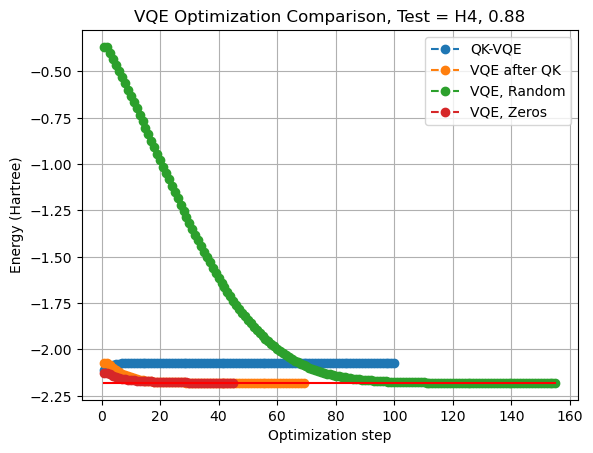

Result of Erros


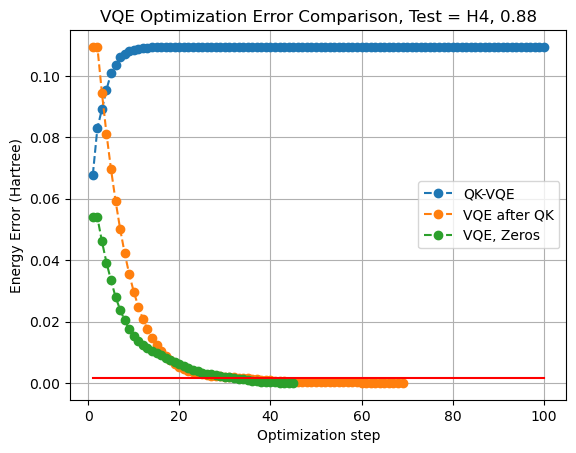


--- Simulation Complete ---


In [19]:
if __name__ == "__main__":
    # ---Hyperparameters ---
    ## LSTM
    ### opt for LSTM train: Adam
    model_type = "QK" #LSTM or OK
    fixed_param_dim = 30
    lr_lstm = 0.002
    lr_mapping = 0.002
    epochs = 10
    #steps_per_epoch = 10
    conv_tol_lstm = 1e-5
    loss_type = "weighted" # weighted or observed improvement
    steps_recurrent_loop_train = 30 # for train (steps_per_epoch)
    steps_recurrent_loop_test = 100 # for test

    ## VQE
    lr_vqe = 0.01
    max_iter_vqe = 500
    conv_tol_vqe = 1e-6
    vqe_optimizer = "ADAM"

    # Data set
    molecule = [
        ("H2", [0.5]),
        ("H2", [0.54]),
        ("H2", [0.58]),
        ("H2", [0.62]),
        ("H2", [0.66]),
        ("H2", [0.82]),
        ("H2", [0.86]),
        ("H2", [0.9]),
        ("H2", [0.94]),
        ("H2", [0.98]),
        ("H2", [1.02]),
        ("H2", [1.06]),
        ("H2", [1.1]),
        ("H2", [1.14]),
        ("H2", [1.18]),
        ("H2", [1.22]),
        ("H2", [1.26]),
        ("H2", [1.3]),
        ("H2", [1.34]),
        ("H2", [1.38]),
        ("H2", [1.42]),
        ("H2", [1.46]),
        ("H2", [1.5]),
        ("H2", [1.54]),
        ("H2", [1.58]),
        ("H2", [1.62]),
        ("H2", [1.66]),
        ("H2", [1.7]),
        ("H2", [1.74]),
        ("H2", [1.78]),
        ("H2", [1.82]),
        ("H2", [1.86]),
        ("H2", [1.9]),
        ("H2", [1.94]),
        ("H2", [1.98]),
        ("H2", [2.02]),
        ("H2", [2.06]),
        ("H2", [2.1]),
        ("H3+", [0.5]),
        ("H3+", [0.54]),
        ("H3+", [0.58]),
        ("H3+", [0.62]),
        ("H3+", [0.66]),
        ("H3+", [0.7]),
        ("H3+", [0.74]),
        ("H3+", [0.78]),
        ("H3+", [0.82]),
        ("H3+", [0.86]),
        ("H3+", [0.9]),
        ("H3+", [0.94]),
        ("H3+", [0.98]),
        ("H3+", [1.02]),
        ("H3+", [1.06]),
        ("H3+", [1.1]),
        ("H3+", [1.26]),
        ("H3+", [1.3]),
        ("H3+", [1.34]),
        ("H3+", [1.38]),
        ("H3+", [1.42]),
        ("H3+", [1.46]),
        ("H3+", [1.5]),
        ("H3+", [1.54]),
        ("H3+", [0.5]),
        ("H2", None),
        ("H3+", None),
        ("H4", None)
        ]

    train_split_index = 65
    # Save File Path
    Data_save_path = "./datasets2/"
    Model_save_path = "model_optuna_conv_params"
    Results_save_path = "model_optuna_conv_result"

    """
    Prepare Dataset
    """
    # load data from pennylane dataset if you have no data
    dataset = molecule_data.load_data(molecule, basis = "STO-3G", folder_path = Data_save_path)
    # If you have data in your computer, then
    # I don't know
    max_qubits, max_s_params, max_d_params, max_params, train_set, test_set = molecule_data.data_params(df = dataset, train_split_index = train_split_index)
    print(f"Train set{train_set}")
    print(f"Test set{test_set}")

    """
    Define model and train
    """
    # --- Model Training ---
    ## define model
    beta_model = LSTM(model_type = model_type,
                       input_feature_dim = fixed_param_dim,
                       max_total_params = max_params,
                       max_qubits = max_qubits,
                       loss_function_type = loss_type,
                        max_s_params = max_s_params,
                        max_d_params = max_d_params
                        )
    
    lstm_params = sum(p.numel() for p in beta_model.lstm.parameters())
    print(f"  {model_type} Parameters: {lstm_params}")
    mapping_params = sum(p.numel() for p in beta_model.mapping.parameters())
    print(f"  Mapping Parameters: {mapping_params}")

    trainer = ModelTrain(beta_model,
                         lr_lstm = lr_lstm,
                         lr_mapping= lr_mapping,
                         num_rnn_iteration = steps_recurrent_loop_train)

    ## train model
    print(f"\n--- Training {model_type} Model ---")

    trainer.train(train_set,
                  epochs = epochs,
                  conv_tol_lstm = conv_tol_lstm)

    torch.save(beta_model.state_dict(), f"{Model_save_path}_{model_type}_{loss_type}.pth")
    print("Model saved successfully!")

    """
    Model Testing
    """
    # --- Model Evaluating ---
    print(f"\n--- Evaluating {model_type} Model ---")


    for i, molecule_data in enumerate(test_set):
        molecule_test_result = {}
        # predicted by model
        #molecule_cost = VQE(molecule_data, max_qubits, True) #max_s_params
        #loss_qnode = molecule_cost.get_loss_function()
        predicted_params_list, predicted_energies_list = trainer.evaluate(
            molecule_data = molecule_data,
            num_rnn_iteration = steps_recurrent_loop_test)

        print(f"the test molecule:{molecule_data.molname}, bondlength: {molecule_data.bondlength}")
        print(f"{model_type} predicted energies:{predicted_energies_list}")

        # use LSTM/QK -FC output as initial params for VQE to optimize
        print(f"\n--- VQE optimization after model ---")
        print(f"the test molecule:{molecule_data.molname}, bondlength: {molecule_data.bondlength}")
        test_vqe = VQE(molecule_data, max_qubits, True) #max_s_params
        opt_lstm_vqe = VQEOptimizer(test_vqe)
        conv_iter_lstm, final_params_lstm, final_energy_lstm, params_history_lstm, energy_history_lstm = opt_lstm_vqe.run_optimization(
            initial_params = predicted_params_list[-1],
            optimizer = vqe_optimizer,
            max_iter = max_iter_vqe,
            learning_rate = lr_vqe,
            conv_tol = conv_tol_vqe
            )

        # VQE predict without guess by LSTM/QK
        print(f"\n--- Standard VQE, random params ---")
        print(f"the test molecule:{molecule_data.molname}, bondlength: {molecule_data.bondlength}")
        # random params
        params_rand = torch.rand(max_params, dtype = torch.float32)
        vqe_test_rand = VQE(molecule_data, max_qubits, False)
        opt_rand_vqe = VQEOptimizer(vqe_test_rand)
        conv_iter_rand, final_params_rand, final_energy_rand, params_history_rand, energy_history_rand = opt_rand_vqe.run_optimization(
            initial_params = params_rand,
            optimizer = vqe_optimizer,
            max_iter = max_iter_vqe,
            learning_rate = lr_vqe,
            conv_tol = conv_tol_vqe
            )

        # params which all zeros
        print(f"\n--- Standard VQE, zero params ---")
        print(f"the test molecule:{molecule_data.molname}, bondlength: {molecule_data.bondlength}")
        params_zeros = torch.zeros(max_params, dtype = torch.float32)
        vqe_test_zeros = VQE(molecule_data, max_qubits, False)
        opt_zeros_vqe = VQEOptimizer(vqe_test_zeros)
        conv_iter_zeros, final_params_zeros, final_energy_zeros, params_history_zeros, energy_history_zeros = opt_rand_vqe.run_optimization(
            initial_params = params_zeros,
            optimizer = vqe_optimizer,
            max_iter = max_iter_vqe,
            learning_rate = lr_vqe,
            conv_tol = conv_tol_vqe
            )
        
        # save result and output as csv
        # result to pd
        molecule_test_result = {
            #'molecule': molecule_data.molname,
            #'bondlength': molecule_data.bondlength,
            'LSTM-VQE': pd.Series(predicted_energies_list),
            'VQE after LSTM':pd.Series(energy_history_lstm),
            'VQE Random': pd.Series(energy_history_rand),
            'VQE Zeros': pd.Series(energy_history_zeros)
            }
        
        df_result = pd.DataFrame(molecule_test_result)
        df_result.to_csv(f"{Results_save_path}_{model_type}_{loss_type}_{molecule_data.molname}_{molecule_data.bondlength}.csv", index = False)
        print("\n--- Saving Complete ---")

        print("Result of VQE Optimization")
        E_fci = test_set[i].fci_energy
        #plt.figure(figsize = (20,10))
        plt.plot(range(1, len(predicted_energies_list) + 1), predicted_energies_list, marker='o', label=f'{model_type}-VQE', ls="dashed")
        plt.plot(range(1, len(energy_history_lstm) + 1), energy_history_lstm, marker='o', label=f'VQE after {model_type}', ls="dashed")
        plt.plot(range(1, len(energy_history_rand) + 1), energy_history_rand, marker='o', label='VQE, Random', ls="dashed")
        plt.plot(range(1, len(energy_history_zeros) + 1), energy_history_zeros, marker='o', label='VQE, Zeros', ls="dashed")
        plt.plot(range(1, len(energy_history_rand) + 1), np.full(len(energy_history_rand) , E_fci), color="red")
        plt.xlabel("Optimization step")
        plt.ylabel("Energy (Hartree)")
        plt.title(f"VQE Optimization Comparison, Test = {molecule_data.molname}, {molecule_data.bondlength}")
        plt.legend()
        plt.grid(True)
        plt.show()

        print("Result of Erros")
        #plt.figure(figsize = (20,10))
        plt.plot(range(1, len(predicted_energies_list) + 1), [item-E_fci for item in predicted_energies_list], marker='o', label=f'{model_type}-VQE', ls="dashed")
        plt.plot(range(1, len(energy_history_lstm) + 1), [item-E_fci for item in energy_history_lstm], marker='o', label=f'VQE after {model_type}', ls="dashed")
        #plt.plot(range(1, len(energy_history_rand) + 1), [item-E_fci for item in energy_history_rand], marker='o', label='VQE, Random', ls="dashed")
        plt.plot(range(1, len(energy_history_zeros) + 1), [item-E_fci for item in energy_history_zeros], marker='o', label='VQE, Zeros', ls="dashed")
        plt.plot(range(1, len(predicted_energies_list) + 1), np.full(len(predicted_energies_list) , 0.0016), color="red")
        plt.xlabel("Optimization step")
        plt.ylabel("Energy Error (Hartree)")
        plt.title(f"VQE Optimization Error Comparison, Test = {molecule_data.molname}, {molecule_data.bondlength}")
        plt.legend()
        plt.grid(True)
        plt.show() 

    print("\n--- Simulation Complete ---")

## 優化

In [9]:
import optuna

In [15]:
model_type = "QK" #LSTM or OK
steps_recurrent_loop_test = 30 # for test

## VQE
lr_vqe = 0.01
max_iter_vqe = 500
conv_tol_vqe = 1e-6
vqe_optimizer = "ADAM"

# Data set
molecule = [
        ("H2", [0.5]),
        ("H2", [0.54]),
        ("H2", [0.58]),
        ("H2", [0.62]),
        ("H2", [0.66]),
        ("H2", [0.82]),
        ("H2", [0.86]),
        ("H2", [0.9]),
        ("H2", [0.94]),
        ("H2", [0.98]),
        ("H2", [1.02]),
        ("H2", [1.06]),
        ("H2", [1.1]),
        ("H2", [1.14]),
        ("H2", [1.18]),
        ("H2", [1.22]),
        ("H2", [1.26]),
        ("H2", [1.3]),
        ("H2", [1.34]),
        ("H2", [1.38]),
        ("H2", [1.42]),
        ("H2", [1.46]),
        ("H2", [1.5]),
        ("H2", [1.54]),
        ("H2", [1.58]),
        ("H2", [1.62]),
        ("H2", [1.66]),
        ("H2", [1.7]),
        ("H2", [1.74]),
        ("H2", [1.78]),
        ("H2", [1.82]),
        ("H2", [1.86]),
        ("H2", [1.9]),
        ("H2", [1.94]),
        ("H2", [1.98]),
        ("H2", [2.02]),
        ("H2", [2.06]),
        ("H2", [2.1]),
        ("H3+", [0.5]),
        ("H3+", [0.54]),
        ("H3+", [0.58]),
        ("H3+", [0.62]),
        ("H3+", [0.66]),
        ("H3+", [0.7]),
        ("H3+", [0.74]),
        ("H3+", [0.78]),
        ("H3+", [0.82]),
        ("H3+", [0.86]),
        ("H3+", [0.9]),
        ("H3+", [0.94]),
        ("H3+", [0.98]),
        ("H3+", [1.02]),
        ("H3+", [1.06]),
        ("H3+", [1.1]),
        ("H3+", [1.26]),
        ("H3+", [1.3]),
        ("H3+", [1.34]),
        ("H3+", [1.38]),
        ("H3+", [1.42]),
        ("H3+", [1.46]),
        ("H3+", [1.5]),
        ("H3+", [1.54]),
        ("H3+", [0.5]),
        ("H2", None),
        ("H3+", None),
        ("H4", [0.5]), # Test
        ("H4", [0.88]),
        ("H4", [1.2]),
        ("LiH", None)
        ]
train_split_index = 65
# Save File Path
Data_save_path = "./datasets1/"
Results_save_path = "model_optim_result2"

# load data from pennylane dataset if you have no data
dataset = molecule_data.load_data(molecule, basis = "STO-3G", folder_path = Data_save_path)
# If you have data in your computer, then
# I don't know
max_qubits, max_s_params, max_d_params, max_params, train_set, test_set = molecule_data.data_params(df = dataset, train_split_index = train_split_index)
print(f"Train set{train_set}")
print(f"Test set{test_set}")


--- Starting Load Data ---

--- Complete Load Data ---
                                                   0
0  <Dataset = molname: H2, basis: STO-3G, bondlen...
1  <Dataset = molname: H2, basis: STO-3G, bondlen...
2  <Dataset = molname: H2, basis: STO-3G, bondlen...
3  <Dataset = molname: H2, basis: STO-3G, bondlen...
4  <Dataset = molname: H2, basis: STO-3G, bondlen...
Train set[<Dataset = molname: H2, basis: STO-3G, bondlength: 0.5, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.54, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.58, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.62, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.66, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.82, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-

In [ ]:
# define an objective function to be min
def objective(trial):
    params = {
        'fixed_param_dim':trial.suggest_int('fixed_param_dim',10, 100),
        'lr_lstm':  trial.suggest_loguniform('lr_lstm',1e-4, 1e-1),
        'lr_mapping': trial.suggest_loguniform('lr_mapping',1e-4, 1e-1),
         'epochs': trial.suggest_int('epochs', 5, 20), 
        'steps_recurrent_loop_train': trial.suggest_int('steps_recurrent_loop_train', 5, 30),
        'loss_type': trial.suggest_categorical('loss_type', ['weighted', 'observed improvement']),

    }

    alpha_model = LSTM(model_type = model_type,
                       input_feature_dim = params['fixed_param_dim'],
                       max_total_params = max_params,
                       max_qubits = max_qubits,
                       loss_function_type = params['loss_type'],
                        max_s_params = max_s_params,
                        max_d_params = max_d_params
                        )

    trainer = ModelTrain(alpha_model,
                         lr_lstm = params['lr_lstm'],
                         lr_mapping= params['lr_mapping'],
                         num_rnn_iteration = params['steps_recurrent_loop_train'])
    
    total_loss = 0
    for molecule_data in train_set:
        vqe = VQE(molecule_data, max_qubits, max_params, True)
        loss_qnode = vqe.get_loss_function()
        loss = trainer.train_step(loss_qnode, vqe, params['steps_recurrent_loop_train'])
        total_loss += loss.item()

    mean_loss = total_loss / len(train_set)

    total_energy_error = 0
    valid_test = 0
    total_iter = 0

    for i, molecule_data in enumerate(test_set):
        predicted_params_list, predicted_energies_list = trainer.evaluate(
            molecule_data = molecule_data,
            num_rnn_iteration = steps_recurrent_loop_test)
        # Calculate the mean energy of lstm_guesses
        predicted_energy = predicted_energies_list[-1]
        experimental_energy = molecule_data.fci_energy
        energy_error = abs(predicted_energy - experimental_energy)/0.0016

        total_energy_error += energy_error
        valid_test +=1

        test_vqe = VQE(molecule_data, max_qubits, True) #max_s_params
        opt_lstm_vqe = VQEOptimizer(test_vqe)
        conv_iter_lstm, final_params_lstm, final_energy_lstm, params_history_lstm, energy_history_lstm = opt_lstm_vqe.run_optimization(
            initial_params = predicted_params_list[-1],
            optimizer = vqe_optimizer,
            max_iter = max_iter_vqe,
            learning_rate = lr_vqe,
            conv_tol = conv_tol_vqe
            )
        
        total_iter += max(0,conv_iter_lstm-45)
    
    mean_total_iter = total_iter / valid_test
    mean_energy_error = total_energy_error / valid_test 
    mean_loss = mean_loss + 0.1*mean_energy_error + 0.05*mean_total_iter
    
    return  mean_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 30, timeout = 3600)

df = study.trials_dataframe()
df.to_csv(f"{model_type}_{Results_save_path}.csv", index = False)

In [17]:
best_trial = study.best_trial
print("Best trial:", best_trial)
print("  Value:", best_trial.value)

print("Best Trial Params:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

Best trial: FrozenTrial(number=3, state=1, values=[15.875037305644263], datetime_start=datetime.datetime(2025, 8, 4, 23, 0, 51, 564339), datetime_complete=datetime.datetime(2025, 8, 4, 23, 14, 53, 932351), params={'fixed_param_dim': 26, 'lr_lstm': 0.002145399128492878, 'lr_mapping': 0.00230461864555723, 'epochs': 9, 'steps_recurrent_loop_train': 27, 'loss_type': 'weighted'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'fixed_param_dim': IntDistribution(high=100, log=False, low=10, step=1), 'lr_lstm': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'lr_mapping': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'epochs': IntDistribution(high=20, log=False, low=5, step=1), 'steps_recurrent_loop_train': IntDistribution(high=30, log=False, low=5, step=1), 'loss_type': CategoricalDistribution(choices=('weighted', 'observed improvement'))}, trial_id=3, value=None)
  Value: 15.875037305644263
Best Trial Params:
  fixed_param_dim: 26
  lr_ls

In [18]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_slice(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()